## View one raft CCD Temp Data

In [4]:
import pandas as pd
s_train = pd.read_csv("../data/focal-plane_R01.tsv", index_col="time", parse_dates=True, squeeze=True)

In [6]:
!ls ../data/ccsTemp

tempR11-Run6.csv tempR21-Run6.csv tempR30-Run6.csv tempR34-Run6.csv
tempR12-Run6.csv tempR22-Run6.csv tempR31-Run6.csv
tempR13-Run6.csv tempR23-Run6.csv tempR32-Run6.csv
tempR14-Run6.csv tempR24-Run6.csv tempR33-Run6.csv


In [11]:
!head ../data/ccsTemp/tempR11-Run6.csv

#
# None
#
# CCS trending dump at 2023-06-30T20:10:24-07:00
# Data for 1209600 total seconds from 1 intervals over 14 days, 0:00:00 (h:m:s) from:
#     tmin=1686677400000.0: "2023-06-13T10:30:00-07:00"
#     tmax=1687887000000.0: "2023-06-27T10:30:00-07:00"
# 'time (ms)'       'value' 'unit'  'channel CCS path'              'iso-8601 Date'               
1686677407924     -99.69018     °C   focal-plane/R11/Reb0/S00/Temp   2023-06-13T10:30:07.924-07:00 
1686677416924     -99.53133     °C   focal-plane/R11/Reb0/S00/Temp   2023-06-13T10:30:16.924-07:00 


In [7]:
path = '../data/ccsTemp/'
regex = path+'temp%s-Run6.csv'

In [75]:
import numpy as np
dt1 = np.dtype({'names': ['time', 'temp', 'channel','datetime'],
                'formats': [int , float, 'U28', 'U28']})
rdata = np.loadtxt(regex%'R11', dt1, usecols=(0, 1, 3, 4))

In [182]:
def read_file(fname):
    # fast reading
    dt1 = np.dtype({'names': ['time', 'temp', 'channel','datetime'],
                'formats': [int , float, 'U28', 'U28']})
    rdata = np.loadtxt(fname, dt1, usecols=(0, 1, 3, 4))
    
    # convert to dataframe
    df = pd.DataFrame(rdata)
    
    # convert datetime to a time-series
    df['datetime'] = pd.to_datetime(df['datetime']).dt.strftime('%d-%m %H:%M:%S')
    df = df.set_index('datetime')
    
    # make sensor, raft-sensor columns
    df['raft-sensor'] = df['channel'].apply(lambda x: '-'.join([x.split('/')[1],x.split('/')[3]]))
    df['sensor'] = df['channel'].apply(lambda x: x.split('/')[3])
    df = df.drop('channel',axis=1)
    
    return df

df = read_file(regex%'R11')
df

,time,temp,raft-sensor,sensor
datetime,,,,
13-06 10:30:07,1686677407924,-99.69018,R11-S00,S00
13-06 10:30:16,1686677416924,-99.53133,R11-S00,S00
13-06 10:30:25,1686677425924,-99.72455,R11-S00,S00
13-06 10:30:34,1686677434924,-99.57778,R11-S00,S00
13-06 10:30:43,1686677443924,-99.58335,R11-S00,S00
...,...,...,...,...
26-06 03:32:13,1687775533517,-102.11370,R11-S22,S22
26-06 03:32:22,1687775542518,-103.13080,R11-S22,S22
26-06 03:32:31,1687775551518,-102.17500,R11-S22,S22


## Group By Each Sensor

In [183]:
# Group the DataFrame by 'Sensor'
grouped = df.groupby('sensor')

# Calculate the sum of values for each sensor group
mean_values = grouped['temp'].median()

# Print the sum of values for each sensor group
print(mean_values)

sensor
S00   -101.83970
S01   -102.22890
S02   -100.06265
S10   -102.30550
S11   -102.15920
S12   -102.52330
S20   -102.27900
S21   -102.03940
S22   -101.73660
Name: temp, dtype: float64


In [184]:
names = list(grouped.groups.keys())

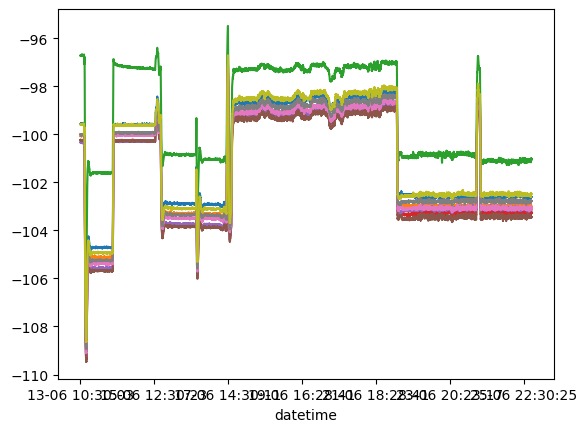

In [185]:
for sensor in names:
    #print('Senor: %s'%sensor)
    grouped.get_group(sensor).temp.rolling(window=100).mean().plot(label=sensor)
    
# plt.legend()

## Outlier Detection

Make a stable time-series selection. To compute the mean values it's important to throw out the bad sensors. Also, remove the peaks.

## Study The $\Delta T$

In [186]:
diff = (grouped.get_group(sensor).temp - df.temp).interpolate()

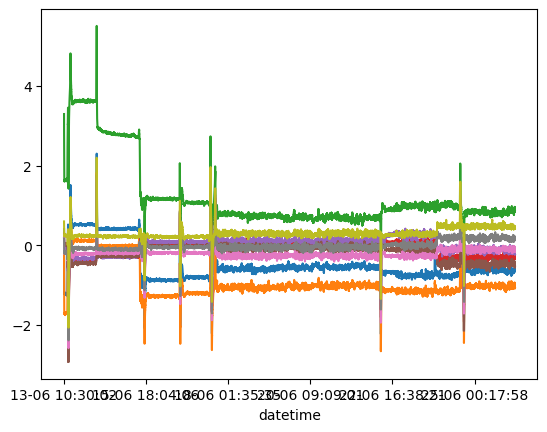

In [189]:
for sensor in names:
    diff = (grouped.get_group(sensor).temp - df.temp.rolling(window=100).median()).interpolate()
    diff.rolling(window=1000).median().plot()

In [188]:
## Find a way to the plot display only the days